#**PART 1 : : Retrieval-Augmented Generation (RAG) Model for QA Bot on P&L Data**

---



## Installations

In [1]:
!pip install tabula-py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.7 MB/s eta 0:00:00


In [2]:
!pip install PyPDF2 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install pdfplumber -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.0 MB/s eta 0:00:00


In [4]:
!pip install pinecone -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.3/427.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 7.3 MB/s eta 0:00:00


##Import Libraries

In [5]:
import pdfplumber
from tabula import read_pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##Load Data

In [ ]:
pdf_path = "/content/Sample Financial Statement.pdf"
tab_data = read_pdf(pdf_path, pages = 3)

In [7]:
tab_df1 = pd.DataFrame(tab_data[0])

In [8]:
# extract tables whose heading consists of Profit and Loss
headings = []
with pdfplumber.open(pdf_path) as pdf:
    for page_num, page in enumerate(pdf.pages):
        text = page.extract_text()
        lines = text.split("\n")

        for line in lines:
            if line.isupper():
                headings.append((page_num + 1, line.strip()))

# Display the extracted headings
for page_num, heading in headings:
    if "profit and loss" in heading.lower():  # Case-sensitive check
        print(f"==>> Page {page_num}: {heading}")
        ext_tab_data = read_pdf(pdf_path, pages = page_num, multiple_tables=True, stream=True)
        tab_df2 = pd.DataFrame(ext_tab_data[0])
        # print("FOUND")
        # print(tab_data_n)

==>> Page 40: 2.24 FUNCTION WISE CLASSIFICATION OF CONDENSED CONSOLIDATED STATEMENT OF PROFIT AND LOSS


Jan 27, 2025 10:12:31 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jan 27, 2025 10:12:31 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jan 27, 2025 10:12:33 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jan 27, 2025 10:12:33 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Jan 27, 2025 10:12:33 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



In [9]:
merged_table_df = pd.concat([tab_df1, tab_df2], ignore_index=True)

In [10]:
merged_table_df

,Condensed Consolidated Statement of Profit and Loss for the,Note No.,"Three months ended March 31,",Unnamed: 0,"Year ended March 31,",Particulars
0,NaN,NaN,2024 2023,NaN,2024 2023,NaN
1,Revenue from operations,2.16,"37,923 37,441",NaN,"153,670 146,767",NaN
2,"Other income, net",2.17,"2,729 671",NaN,"4,711 2,701",NaN
3,Total income,NaN,"40,652 38,112",NaN,"158,381 149,468",NaN
4,Expenses,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
78,NaN,NaN,"7,975 6,134",NaN,"26,248 24,108",NaN
79,NaN,NaN,NaN,NaN,NaN,Total comprehensive income attributable to:
80,NaN,NaN,"7,821 6,276",NaN,"26,754 24,598",Owners of the Company
81,NaN,NaN,2 7,NaN,14 24,Non-controlling interests


##Data Preprocessing

In [11]:
merged_table_df['Condensed Consolidated Statement of Profit and Loss for the'] = merged_table_df['Condensed Consolidated Statement of Profit and Loss for the'].combine_first(merged_table_df['Particulars'])

#correcting the structure to not miss any extracted information. [sub headings]
occurrence_count = 0
for index, row in merged_table_df.iterrows():
    if row['Three months ended March 31,'] == '2024 2023':
        occurrence_count += 1
        if occurrence_count == 1:
            merged_table_df.at[index, 'Condensed Consolidated Statement of Profit and Loss for the'] = 'Condensed Consolidated Statement of Profit and Loss for the'
        elif occurrence_count == 2:
            merged_table_df.at[index, 'Condensed Consolidated Statement of Profit and Loss for the'] = 'Particulars'

In [12]:
# renaming column name
merged_table_df.rename(columns={'Condensed Consolidated Statement of Profit and Loss for the': 'Description'}, inplace=True)

In [13]:
# null column removal
merged_table_df = merged_table_df.loc[:, ~(merged_table_df.isna() | (merged_table_df == ' ')).all()]

In [14]:
merged_table_df[['Three months ended March 31(2024)', 'Three months ended March 31(2023)']] = merged_table_df['Three months ended March 31,'].str.split(' ', expand=True)
merged_table_df[['Year ended March 31(2024)', 'Year ended March 31(2023)']] = merged_table_df['Year ended March 31,'].str.split(' ', expand=True)
merged_table_df.drop(columns=['Particulars', 'Three months ended March 31,','Year ended March 31,'], inplace=True)

In [15]:
merged_table_df = merged_table_df.replace({None: 0.0})
merged_table_df = merged_table_df.replace({np.nan: 0.0})

In [16]:
merged_table_df

,Description,Note No.,Three months ended March 31(2024),Three months ended March 31(2023),Year ended March 31(2024),Year ended March 31(2023)
0,Condensed Consolidated Statement of Profit and...,0.00,2024,2023,2024,2023
1,Revenue from operations,2.16,"37,923","37,441","153,670","146,767"
2,"Other income, net",2.17,"2,729",671,"4,711","2,701"
3,Total income,0.00,"40,652","38,112","158,381","149,468"
4,Expenses,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
78,0.0,0.00,"7,975","6,134","26,248","24,108"
79,Total comprehensive income attributable to:,0.00,0.0,0.0,0.0,0.0
80,Owners of the Company,0.00,"7,821","6,276","26,754","24,598"
81,Non-controlling interests,0.00,2,7,14,24


##Visuals

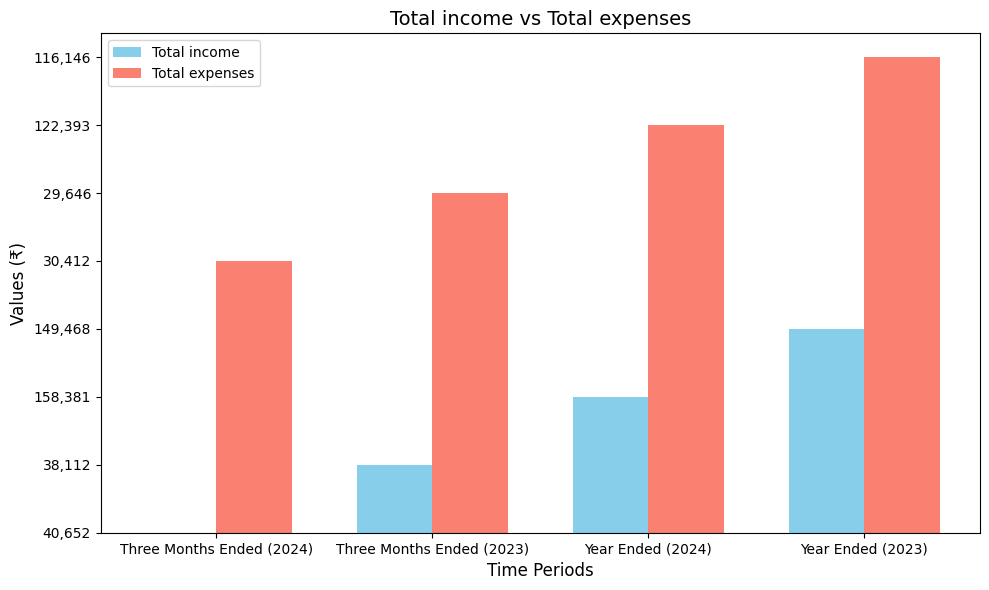

In [17]:
filtered_df = merged_table_df[merged_table_df['Description'].isin(['Total income', 'Total expenses'])]
# Extract columns for x-axis and y-axis
x_axis = ['Three Months Ended (2024)', 'Three Months Ended (2023)', 'Year Ended (2024)', 'Year Ended (2023)']
revenue_values = filtered_df[filtered_df['Description'] == 'Total income'].iloc[0, 2:].values
expenses_values = filtered_df[filtered_df['Description'] == 'Total expenses'].iloc[0, 2:].values

x = np.arange(len(x_axis))
width = 0.35  # Width of the bars

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, revenue_values, width, label='Total income', color='skyblue')
plt.bar(x + width/2, expenses_values, width, label='Total expenses', color='salmon')

plt.xlabel('Time Periods', fontsize=12)
plt.ylabel('Values (₹)', fontsize=12)
plt.title('Total income vs Total expenses', fontsize=14)
plt.xticks(x, x_axis, rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

##Embedding for RAG model

In [18]:
data_for_embedding = merged_table_df.apply(lambda row: f"{row['Description']} | Note No: {row['Note No.']} | 2024 Q1: {row['Three months ended March 31(2024)']} | 2023 Q1: {row['Three months ended March 31(2023)']} | 2024 Year: {row['Year ended March 31(2024)']} | 2023 Year: {row['Year ended March 31(2023)']}", axis=1)

In [19]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(data_for_embedding.tolist()) # embedding of each row

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
pinecone_data = [
    (
        int(i),  # Unique ID for each row
        embeddings[i].tolist(),  # Embedding vector
        # row.to_dict()  # Metadata from the original DataFrame
        merged_table_df.iloc[i].to_dict()
    )
    for i, (_, row) in enumerate(merged_table_df.iterrows())
]

In [21]:
# metadata={}
# for i, (_, row) in enumerate(merged_table_df.iterrows()):
#   metadata = merged_table_df.iloc[i].to_dict()

##PineCone Initialise and upsert Embeddings

In [22]:
from pinecone import Pinecone
pc = Pinecone(api_key="API", environment="us-east-1")

In [23]:
index = pc.Index("jb-sample-set")
records = []
for d, e in zip(pinecone_data, embeddings):
  records.append({
      "id": str(d[0]),
      "values": d[1],
      "metadata": d[2]
  })

# Upsert the records into the index
index.upsert(
    vectors=records,
    namespace="sample-set-pl"
)
print("Data successfully upserted into Pinecone!")

Data successfully upserted into Pinecone!


##Testing the model with several financial queries

In [42]:
def test_queries(query):
  query_embedding = model.encode([query])  # Encode the query into an embedding
  query_vector = query_embedding[0].tolist()
  # Query Pinecone for the top 3 most similar vectors
  results = index.query(
      vector=query_vector,
      top_k=3,              # Retrieve top 3 matches
      include_metadata=True,
      namespace="sample-set-pl"
  )

  # Print the results
  for match in results["matches"]:
    print(f"ID: {match['id']}, Score: {match['score']}, Metadata: {match['metadata']}")

In [43]:
test_queries("What is the gross profit?") # the first result is the one we are looking for with score 0.733

ID: 50, Score: 0.732952654, Metadata: {'Description': 'Gross profit', 'Note No.': 0.0, 'Three months ended March 31(2023)': '11,430', 'Three months ended March 31(2024)': '11,175', 'Year ended March 31(2023)': '44,414', 'Year ended March 31(2024)': '46,257'}
ID: 55, Score: 0.642771065, Metadata: {'Description': 'Operating profit', 'Note No.': 0.0, 'Three months ended March 31(2023)': '7,877', 'Three months ended March 31(2024)': '7,621', 'Year ended March 31(2023)': '30,905', 'Year ended March 31(2024)': '31,747'}
ID: 15, Score: 0.58721149, Metadata: {'Description': 'Profit before tax', 'Note No.': 0.0, 'Three months ended March 31(2023)': '8,466', 'Three months ended March 31(2024)': '10,240', 'Year ended March 31(2023)': '33,322', 'Year ended March 31(2024)': '35,988'}


In [44]:
test_queries("What is the gross profit for Q1 2024?") # the same query with more info increases the similarity score to 0.805

ID: 50, Score: 0.807269454, Metadata: {'Description': 'Gross profit', 'Note No.': 0.0, 'Three months ended March 31(2023)': '11,430', 'Three months ended March 31(2024)': '11,175', 'Year ended March 31(2023)': '44,414', 'Year ended March 31(2024)': '46,257'}
ID: 55, Score: 0.753427923, Metadata: {'Description': 'Operating profit', 'Note No.': 0.0, 'Three months ended March 31(2023)': '7,877', 'Three months ended March 31(2024)': '7,621', 'Year ended March 31(2023)': '30,905', 'Year ended March 31(2024)': '31,747'}
ID: 15, Score: 0.745880902, Metadata: {'Description': 'Profit before tax', 'Note No.': 0.0, 'Three months ended March 31(2023)': '8,466', 'Three months ended March 31(2024)': '10,240', 'Year ended March 31(2023)': '33,322', 'Year ended March 31(2024)': '35,988'}


In [45]:
test_queries("What is the total income for Q1 2024?")

ID: 3, Score: 0.772541881, Metadata: {'Description': 'Total income', 'Note No.': 0.0, 'Three months ended March 31(2023)': '38,112', 'Three months ended March 31(2024)': '40,652', 'Year ended March 31(2023)': '149,468', 'Year ended March 31(2024)': '158,381'}
ID: 63, Score: 0.754531324, Metadata: {'Description': 'Other comprehensive income', 'Note No.': 0.0, 'Three months ended March 31(2023)': 0.0, 'Three months ended March 31(2024)': 0.0, 'Year ended March 31(2023)': 0.0, 'Year ended March 31(2024)': 0.0}
ID: 20, Score: 0.754531324, Metadata: {'Description': 'Other comprehensive income', 'Note No.': 0.0, 'Three months ended March 31(2023)': 0.0, 'Three months ended March 31(2024)': 0.0, 'Year ended March 31(2023)': 0.0, 'Year ended March 31(2024)': 0.0}


In [46]:
test_queries("What is the net income for Q1 2024?") # returns results from both the P&L table and FUNCTION WISE CLASSIFICATION of P&L table

ID: 2, Score: 0.777328372, Metadata: {'Description': 'Other income, net', 'Note No.': 2.17, 'Three months ended March 31(2023)': '671', 'Three months ended March 31(2024)': '2,729', 'Year ended March 31(2023)': '2,701', 'Year ended March 31(2024)': '4,711'}
ID: 56, Score: 0.777328372, Metadata: {'Description': 'Other income, net', 'Note No.': 2.17, 'Three months ended March 31(2023)': '671', 'Three months ended March 31(2024)': '2,729', 'Year ended March 31(2023)': '2,701', 'Year ended March 31(2024)': '4,711'}
ID: 20, Score: 0.72824651, Metadata: {'Description': 'Other comprehensive income', 'Note No.': 0.0, 'Three months ended March 31(2023)': 0.0, 'Three months ended March 31(2024)': 0.0, 'Year ended March 31(2023)': 0.0, 'Year ended March 31(2024)': 0.0}
